In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from os.path import expanduser, join
from glob import glob
from shapely.geometry import Point, box
import pickle
import contextily as ctx
import rioxarray as rxa
import seaborn as sns

In [3]:
pits = gpd.read_file('/bsuhome/zacharykeskinen/scratch/data/uavsar/snowpits/SNEX20_TS_SP_Summary_SWE_v01.csv')
for i, r in pits.iterrows():
    pits.loc[i, 'geometry'] = Point(float(r['Longitude (deg)']), float(r['Latitude (deg)']))
with open(expanduser('~/scratch/data/uavsar/image_fps'), 'rb') as f:
    image_fps = pickle.load(f)

In [4]:
locs_dic = {'American River Basin':'Eldorado National Forest, CA', 'Boise River Basin':'-1', 'Cameron Pass': 'Rocky Mountains NP, CO', \
    'East River':'Peeler Peak, CO','Fraser Experimental Forest':'Fraser, CO', 'Grand Mesa':'Grand Mesa, CO',\
    'Jemez River':'Los Alamos, NM','Little Cottonwood Canyon':'Salt Lake City, UT','Mammoth Lakes':'Sierra National Forest, CA',\
    'Niwot Ridge':'Rocky Mountains NP, CO','Sagehen Creek':'Los Alamos, NM','Senator Beck':'Ironton, CO'}

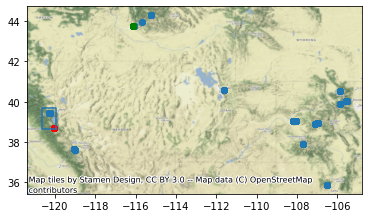

In [5]:
fig, ax = plt.subplots()
pits.plot(ax = ax)
pits[pits.Location == 'American River Basin'].plot(ax = ax, color ='red')
pits[(pits.Location == 'Boise River Basin') & (pits.Site == 'LDP Open')].plot(ax = ax, color = 'green')
ua = rxa.open_rasterio([fps for fps in image_fps if fps['location'] == 'Eldorado National Forest, CA'][0]['fp'])
bbox = box(*ua.rio.bounds())
ax.plot(*bbox.exterior.xy)
ctx.add_basemap(ax, crs = 'EPSG:4326')

In [6]:
cors = []
sds = []
for i, r in pits.iterrows():
    if r['Location'] != 'Boise River Basin':
        img_loc = locs_dic[r['Location']]
    else:
        if 'LDP' in r.Site:
            img_loc = 'Silver City, ID'
        else:
            img_loc = 'Lowman, CO'
    
    date = pd.to_datetime(r['Date/Local Standard Time'])
    if 'CA' not in img_loc:
        date = date.tz_localize('US/Mountain')
    else:
        date = date.tz_localize('US/Pacific')
    uavsar_images = [fps for fps in image_fps if fps['location'] == img_loc]
    between = [i for i in uavsar_images if (i['flight1'] - pd.Timedelta('1 days') < date) & (i['flight2'] + pd.Timedelta('1 days') > date)  & (i['pol'] == 'VV')]
    if len(between) > 0:
        for b in between:
            cor = rxa.open_rasterio(b['cor'])
            cor_pit = cor.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest').values
            siteDetails = pd.read_csv(glob(join('/bsuhome/zacharykeskinen/scratch/data/uavsar/snowpits/pits', r.PitID ,'*siteDetails*'))[0], index_col = '# Location')
            trees = siteDetails.loc['# Tree Canopy'].iloc[0]
            groundwet = siteDetails.loc['# Ground Condition'].iloc[0]

            temp = pd.read_csv(glob(join('/bsuhome/zacharykeskinen/scratch/data/uavsar/snowpits/pits', r.PitID ,'*temperature*'))[0], index_col = '# Location')
            temp_min = temp.loc[[i for i in temp.index if '# ' not in i]].astype(float).max().iloc[0]
            if trees == 'No Trees' and groundwet == 'Frozen' and temp_min < -1 :
                if ~np.isnan(cor_pit):
                    cors.append(cor_pit[0])
                    sds.append(float(r['SWE (mm)']))

In [7]:
from scipy import stats
def r2_value(x, y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    print(f'slope: {slope}. intercept: {intercept}. r_value {r_value}. p value: {p_value}')
    return slope, intercept, r_value, p_value, x, y

slope: -0.0013241665557872505. intercept: 1.024241875380819. r_value -0.3996514028228805. p value: 0.014260255149208869


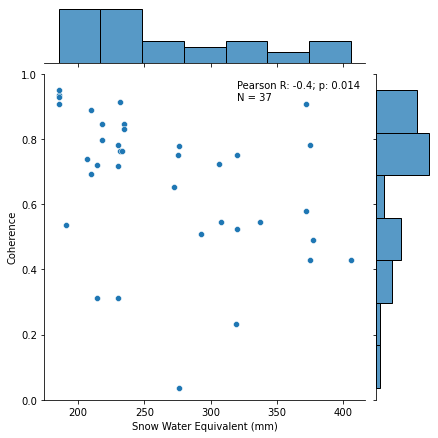

In [8]:
figdir = '/bsuhome/zacharykeskinen/uavsar/figures/snowpit_compare'
slope, intercept, r, p, x, y = r2_value(sds, cors)
plt.Figure(figsize = (12,8))
n = 1
g = sns.jointplot(x = sds, y = cors, kind = 'scatter',ylim = (0,1), cmap='Blues')
n = len(cors)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}\nN = {n}', xy = [0.6,0.92], xycoords = 'axes fraction')

g.ax_joint.set_xlabel('Snow Water Equivalent (mm)')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join(figdir, 'swe-cor.png'))

In [9]:
cors = []
sds = []
for i, r in pits.iterrows():
    if r['Location'] != 'Boise River Basin':
        img_loc = locs_dic[r['Location']]
    else:
        if 'LDP' in r.Site:
            img_loc = 'Silver City, ID'
        else:
            img_loc = 'Lowman, CO'
    
    date = pd.to_datetime(r['Date/Local Standard Time'])
    if 'CA' not in img_loc:
        date = date.tz_localize('US/Mountain')
    else:
        date = date.tz_localize('US/Pacific')
    uavsar_images = [fps for fps in image_fps if fps['location'] == img_loc]
    between = [i for i in uavsar_images if (i['flight1'] - pd.Timedelta('1 days') < date) & (i['flight2'] + pd.Timedelta('1 days') > date)  & (i['pol'] == 'VV')]
    if len(between) > 0:
        for b in between:
            cor = rxa.open_rasterio(b['cor'])
            cor_pit = cor.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest').values
            siteDetails = pd.read_csv(glob(join('/bsuhome/zacharykeskinen/scratch/data/uavsar/snowpits/pits', r.PitID ,'*siteDetails*'))[0], index_col = '# Location')
            trees = siteDetails.loc['# Tree Canopy'].iloc[0]
            groundwet = siteDetails.loc['# Ground Condition'].iloc[0]

            temp = pd.read_csv(glob(join('/bsuhome/zacharykeskinen/scratch/data/uavsar/snowpits/pits', r.PitID ,'*temperature*'))[0], index_col = '# Location')
            temp_min = temp.loc[[i for i in temp.index if '# ' not in i]].astype(float).min().iloc[0]

            strat = pd.read_csv(glob(join('/bsuhome/zacharykeskinen/scratch/data/uavsar/snowpits/pits', r.PitID ,'*strat*'))[0], comment = '#', names = ['Top (cm)','Bottom (cm)','Grain Size (mm)','Grain Type','Hand Hardness','Manual Wetness','Comments'])
            wet_depth = 0
            for i_pit, r_pit in strat.iterrows():
                if r_pit['Manual Wetness'] != 'D':
                    wet_depth += r_pit['Top (cm)'] - r_pit['Bottom (cm)']
            # if trees == 'No Trees' and groundwet == 'Frozen' and temp_min < -1 :
            if ~np.isnan(cor_pit) and wet_depth > 0 and trees == 'No Trees':
                cors.append(cor_pit[0])
                sds.append(wet_depth/strat.iloc[0,0])

slope: 0.1464986819842746. intercept: 0.45680642363615936. r_value 0.261324498541282. p value: 0.09459221588140819


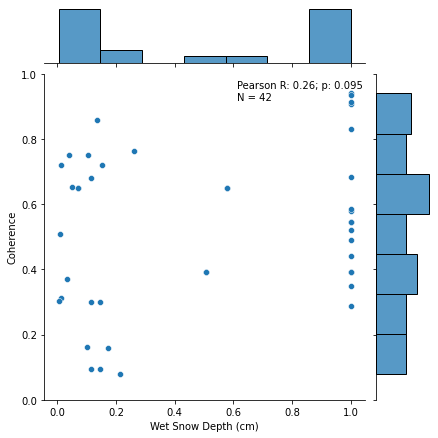

In [10]:
figdir = '/bsuhome/zacharykeskinen/uavsar/figures/snowpit_compare'
slope, intercept, r, p, x, y = r2_value(sds, cors)
plt.Figure(figsize = (12,8))
n = 1
g = sns.jointplot(x = sds, y = cors, kind = 'scatter',ylim = (0,1), cmap='Blues')
n = len(cors)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}\nN = {n}', xy = [0.6,0.92], xycoords = 'axes fraction')

g.ax_joint.set_xlabel('Wet Snow Depth (cm)')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join(figdir, 'wet-cor.png'))

In [15]:
cor_wet = []
cor_dry = []
for i, r in pits.iterrows():
    if r['Location'] != 'Boise River Basin':
        img_loc = locs_dic[r['Location']]
    else:
        if 'LDP' in r.Site:
            img_loc = 'Silver City, ID'
        else:
            img_loc = 'Lowman, CO'
    
    date = pd.to_datetime(r['Date/Local Standard Time'])
    if 'CA' not in img_loc:
        date = date.tz_localize('US/Mountain')
    else:
        date = date.tz_localize('US/Pacific')
    uavsar_images = [fps for fps in image_fps if fps['location'] == img_loc]
    between = [i for i in uavsar_images if (i['flight1'] - pd.Timedelta('1 days') < date) & (i['flight2'] + pd.Timedelta('1 days') > date)  & (i['pol'] == 'VV')]
    if len(between) > 0:
        for b in between:
            cor = rxa.open_rasterio(b['cor'])
            cor_pit = cor.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest').values
            siteDetails = pd.read_csv(glob(join('/bsuhome/zacharykeskinen/scratch/data/uavsar/snowpits/pits', r.PitID ,'*siteDetails*'))[0], index_col = '# Location')
            trees = siteDetails.loc['# Tree Canopy'].iloc[0]
            groundwet = siteDetails.loc['# Ground Condition'].iloc[0]

            temp = pd.read_csv(glob(join('/bsuhome/zacharykeskinen/scratch/data/uavsar/snowpits/pits', r.PitID ,'*temperature*'))[0], index_col = '# Location')
            temp_min = temp.loc[[i for i in temp.index if '# ' not in i]].astype(float).min().iloc[0]

            strat = pd.read_csv(glob(join('/bsuhome/zacharykeskinen/scratch/data/uavsar/snowpits/pits', r.PitID ,'*strat*'))[0], comment = '#', names = ['Top (cm)','Bottom (cm)','Grain Size (mm)','Grain Type','Hand Hardness','Manual Wetness','Comments'])
            wet_depth = 0
            for i_pit, r_pit in strat.iterrows():
                if r_pit['Manual Wetness'] != 'D':
                    wet_depth += r_pit['Top (cm)'] - r_pit['Bottom (cm)']
            # if trees == 'No Trees' and groundwet == 'Frozen' and temp_min < -1 :
            if ~np.isnan(cor_pit) and wet_depth > 0 and trees == 'No Trees':
                cor_wet.append(cor_pit[0])
            elif ~np.isnan(cor_pit) and wet_depth == 0 and trees == 'No Trees':
                cor_dry.append(cor_pit[0])

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

ax = sns.violinplot(y="day", x="total_bill", data=tips,
                    palette=palette,
                    scale="width", inner=None)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
for violin in ax.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width, height / 2, transform=ax.transData))

sns.boxplot(y="day", x="total_bill", data=tips, saturation=1, showfliers=False,
            width=0.3, boxprops={'zorder': 3, 'facecolor': 'none'}, ax=ax)
old_len_collections = len(ax.collections)
sns.stripplot(y="day", x="total_bill", data=tips, color='dodgerblue', ax=ax)
for dots in ax.collections[old_len_collections:]:
    dots.set_offsets(dots.get_offsets() + np.array([0, 0.12]))
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

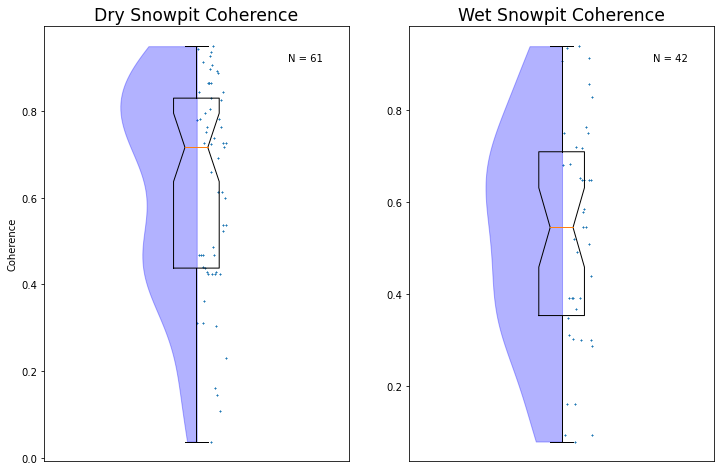

In [63]:
f, (ax, ax2) = plt.subplots(1, 2, figsize = (12,8))
ax.scatter(x = np.ones_like(cor_dry) + 0.1 * np.random.random(len(cor_dry)), y = cor_dry, s = 1, marker = 'x')
ax.boxplot(cor_dry, notch = True)
v1 = ax.violinplot(cor_dry, showextrema=False)
for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
    b.set_color('b')

ax2.scatter(x = np.ones_like(cor_wet) + 0.1 * np.random.random(len(cor_wet)), y = cor_wet, s = 1, marker = 'x')
ax2.boxplot(cor_wet, notch = True)
v1 = ax2.violinplot(cor_wet, showextrema=False)
for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
    b.set_color('b')

ax.set_title('Dry Snowpit Coherence', fontdict= {'fontsize': 'xx-large'})
ax2.set_title('Wet Snowpit Coherence', fontdict= {'fontsize': 'xx-large'})

n = len(cor_dry)
ax.annotate(f'N = {n}', xy = [0.8,0.92], xycoords = 'axes fraction' )

n = len(cor_wet)
ax2.annotate(f'N = {n}', xy = [0.8,0.92], xycoords = 'axes fraction' )

for a in [ax, ax2]:
    a.get_xaxis().set_visible(False)

ax.set_ylabel('Coherence')
plt.savefig(join(figdir, 'snowpit-violin-wet-dry.png'))

In [13]:
cors = []
sds = []
for i, r in pits.iterrows():
    if r['Location'] != 'Boise River Basin':
        img_loc = locs_dic[r['Location']]
    else:
        if 'LDP' in r.Site:
            img_loc = 'Silver City, ID'
        else:
            img_loc = 'Lowman, CO'
    
    date = pd.to_datetime(r['Date/Local Standard Time'])
    if 'CA' not in img_loc:
        date = date.tz_localize('US/Mountain')
    else:
        date = date.tz_localize('US/Pacific')
    uavsar_images = [fps for fps in image_fps if fps['location'] == img_loc]
    between = [i for i in uavsar_images if (i['flight1'] - pd.Timedelta('1 days') < date) & (i['flight2'] + pd.Timedelta('1 days') > date)  & (i['pol'] == 'VV')]
    if len(between) > 0:
        for b in between:
            cor = rxa.open_rasterio(b['cor'])
            cor_pit = cor.sel(x = r.geometry.x, y = r.geometry.y, method = 'nearest').values
            siteDetails = pd.read_csv(glob(join('/bsuhome/zacharykeskinen/scratch/data/uavsar/snowpits/pits', r.PitID ,'*siteDetails*'))[0], index_col = '# Location')
            trees = siteDetails.loc['# Tree Canopy'].iloc[0]
            groundwet = siteDetails.loc['# Ground Condition'].iloc[0]

            temp = pd.read_csv(glob(join('/bsuhome/zacharykeskinen/scratch/data/uavsar/snowpits/pits', r.PitID ,'*temperature*'))[0], index_col = '# Location')
            temp_min = temp.loc[[i for i in temp.index if '# ' not in i]].astype(float).min().iloc[0]

            strat = pd.read_csv(glob(join('/bsuhome/zacharykeskinen/scratch/data/uavsar/snowpits/pits', r.PitID ,'*strat*'))[0], comment = '#', names = ['Top (cm)','Bottom (cm)','Grain Size (mm)','Grain Type','Hand Hardness','Manual Wetness','Comments'])
            wet_depth = 0
            for i_pit, r_pit in strat.iterrows():
                if r_pit['Manual Wetness'] != 'D':
                    wet_depth += r_pit['Top (cm)'] - r_pit['Bottom (cm)']
            # if trees == 'No Trees' and groundwet == 'Frozen' and temp_min < -1 :
            if ~np.isnan(cor_pit) and trees == 'No Trees':
                cors.append(cor_pit[0])
                sds.append(wet_depth)

slope: -9.394635945507748e-05. intercept: 0.5895389684623207. r_value -0.018788083992771595. p value: 0.8505883707765435


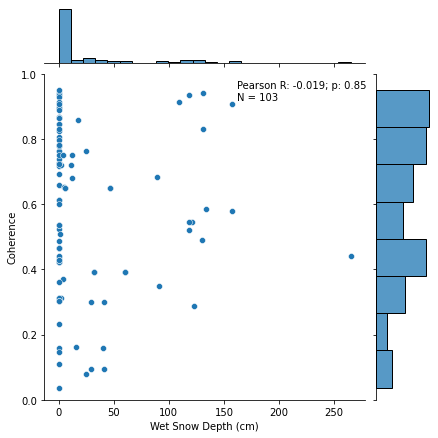

In [14]:
figdir = '/bsuhome/zacharykeskinen/uavsar/figures/snowpit_compare'
slope, intercept, r, p, x, y = r2_value(sds, cors)
plt.Figure(figsize = (12,8))
n = 1
g = sns.jointplot(x = sds, y = cors, kind = 'scatter',ylim = (0,1), cmap='Blues')
n = len(cors)
g.ax_joint.annotate(text = f'Pearson R: {r:.2}; p: {p:.2}\nN = {n}', xy = [0.6,0.92], xycoords = 'axes fraction')

g.ax_joint.set_xlabel('Wet Snow Depth (cm)')
g.ax_joint.set_ylabel('Coherence')
plt.savefig(join(figdir, 'wet-cor.png'))